In [1]:
import numpy as np
from matplotlib_rc import *
import scipy.optimize as opt
import pandas as pd
import toolbox
from cov import cov_ellipse,cov_ellipse_xy

Rq_exp=np.array([3.477,4.2694,5.501])
BE_exp=np.array([8.667,8.710,7.867])
Fw_exp=np.array([0.1304,0.368])
Fw_sig2=np.array([0.0052**2+0.002**2,0.013**2])
Fc_exp=np.array([0.1581,0.409])

(0.02, 0.06)

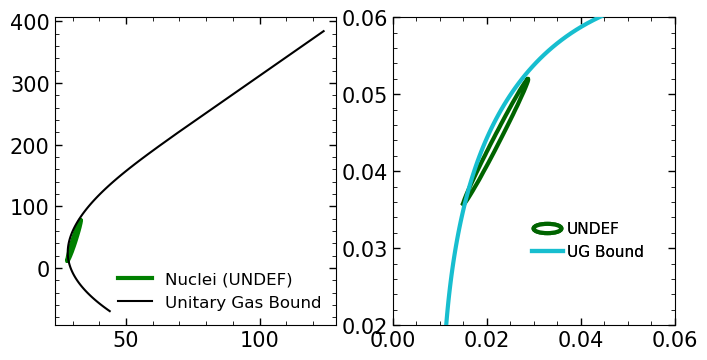

In [2]:
fig,ax=plt.subplots(1,2,figsize=(8,4),sharex=False,sharey=False)

# Nuclei Masses https://journals.aps.org/prc/abstract/10.1103/PhysRevC.82.024313
data_SvL_masses = pd.read_csv("./data/masses.csv",names=['Esym', 'L'])
ax[0].plot(np.array(data_SvL_masses['Esym']),np.array(data_SvL_masses['L']),lw=3,color='g',label='Nuclei (UNDEF)')

# Unitary gas limit https://iopscience.iop.org/article/10.3847/1538-4357/aa8db9/meta
n0 = 0.157 # fm**-3
hbarc = 197.3269718 # MeV fm
Mn = 939.565379; # MeV
EUG0 = 3./(10.*Mn) * np.cbrt(3.*np.pi**2*n0)**2*hbarc**2*0.365 # about 12.64 MeV
E0 = -15.5 # MeV

TewsEtAlSetting = {
    "EUG0" : EUG0, "E0" : E0, "Kn" : 270,
    "Qnlower" : -750., "Qnupper" : 0.
}
def getUgConstraint( ut, EUG0, Kn, Qnlower, Qnupper, E0 ):
    taylorDiff = ut-1.
    Qn = np.where(ut < 1, Qnlower, Qnupper)
    Esym = EUG0/(3.*np.cbrt(ut)) * (ut+2.) + Kn/18. * taylorDiff**2 + Qn/81. * taylorDiff**3 - E0
    L = 2.*EUG0/(np.cbrt(ut)) - Kn/3. * taylorDiff - Qn/18. * taylorDiff**2
    return Esym, L

def getUgAnalyticConstraint( L, EUG0, E0 ):
    return L/6. * ( 1. + 2. * (2.* EUG0 / L)**(3/2) ) - E0
ut = np.linspace(0.001, 2, 100)
tews_zorder = 11
Esym_tews, L_tews = getUgConstraint( ut, **TewsEtAlSetting)
ax[0].plot(Esym_tews, L_tews, c='k', zorder=tews_zorder,label='Unitary Gas Bound')
ax[0].legend(frameon=False,fontsize=12,loc='lower right')


def FchFw_from_SvL(Sv,L,abc_Sv,abc_L):
    FchFw_Ca_masses=((Sv-abc_Sv[2])/abc_Sv[1]-(L-abc_L[2])/abc_L[1])/(abc_Sv[0]/abc_Sv[1]-abc_L[0]/abc_L[1])
    FchFw_Pb_masses=((Sv-abc_Sv[2])/abc_Sv[0]-(L-abc_L[2])/abc_L[0])/(abc_Sv[1]/abc_Sv[0]-abc_L[1]/abc_L[0])
    return np.array([FchFw_Ca_masses,FchFw_Pb_masses])
#Sv
Skyrme_Sv_fit=np.array([[-503.15403534,  945.22127475,   31.89221938], [7.82761983, 5.47575785, np.sqrt(0.26055098**2+2.907991479720574**2)]])
RMF_Sv_fit   =np.array([[-575.16334707,  916.25267173,   32.21119673], [5.11908268, 4.57687047,  np.sqrt(0.1362248**2+3.7078478498636382**2)]])
#L
Skyrme_L_fit=np.array([[1791.16521898, 2652.03528358,  -91.50211979], [27.20594561, 19.03154168,  np.sqrt(0.90572546**2+10.108477749412812**2)]])
RMF_L_fit   =np.array([[2938.73372836, 2420.6187724,  -149.77347236], [43.53273969, 33.94649156,  np.sqrt(1.44853764**2+25.5606440235324**2)]])

FchFw_PbCa_masses=FchFw_from_SvL(data_SvL_masses['Esym'],data_SvL_masses['L'],Skyrme_Sv_fit[0],Skyrme_L_fit[0])
FchFw_PbCa_UG    =FchFw_from_SvL(Esym_tews, L_tews,Skyrme_Sv_fit[0],Skyrme_L_fit[0])

ax[1].plot(FchFw_PbCa_masses[1],FchFw_PbCa_masses[0],lw=3,color='darkgreen')#,label='Nuclei (UNDEF)')
line_mass=ax[1].plot([0],[0],ls='',marker=toolbox.ellipse_marker,ms=20,markerfacecolor='w',markeredgewidth=3,markeredgecolor='darkgreen',label='UNDEF')

line_UG=ax[1].plot(FchFw_PbCa_UG[1], FchFw_PbCa_UG[0], c='tab:cyan', lw=3,zorder=tews_zorder,label='UG Bound')
legend=ax[1].legend(handles=line_mass+line_UG,fontsize=11,frameon=False,handletextpad=0.3, loc='lower left', bbox_to_anchor=(0.445, 0.17))
ax[1].add_artist(legend)

ax[1].set_xlim(0,0.06)
ax[1].set_ylim(0.02,0.06)

In [3]:
likelihood_name=['$R_{ch}, F_{ch}, BE$','+CREX+PREX','+CREX','+PREX']
likelihood_filename=['none','all','crex','prex']

from load_all_data import *
PrexCrex_RMF_plot=np.array(list(dict(zip(PrexCrex_RMF[0],PrexCrex_RMF.transpose())).values())).transpose()
eos_args_RMF_plot=np.array(list(dict(zip(PrexCrex_RMF[0],eos_args_RMF.transpose())).values())).transpose()
SAT_RMF_plot     =np.array(list(dict(zip(PrexCrex_RMF[0],SAT_RMF.transpose())).values())).transpose()
SAT_PNM_RMF_plot =np.array(list(dict(zip(PrexCrex_RMF[0],SAT_PNM_RMF.transpose())).values())).transpose()
BulK_L_RMF_plot  =np.array(list(dict(zip(PrexCrex_RMF[0],BulK_L_RMF.transpose())).values())).transpose()
BulK_P_RMF_plot  =np.array(list(dict(zip(PrexCrex_RMF[0],BulK_P_RMF.transpose())).values())).transpose()

# PrexCrex_RMF_to_Skyrme_plot=np.array(list(dict(zip(PrexCrex_RMF[0],PrexCrex_RMF_to_Skyrme.transpose())).values())).transpose()
# eos_args_RMF_to_Skyrme_plot=np.array(list(dict(zip(PrexCrex_RMF[0],eos_args_RMF_to_Skyrme.transpose())).values())).transpose()
# SAT_RMF_to_Skyrme_plot     =np.array(list(dict(zip(PrexCrex_RMF[0],SAT_RMF_to_Skyrme.transpose())).values())).transpose()
# SAT_PNM_RMF_to_Skyrme_plot =np.array(list(dict(zip(PrexCrex_RMF[0],SAT_PNM_RMF_to_Skyrme.transpose())).values())).transpose()


Skyrme
a,b,c= [-503.15403534  945.22127475   31.89221938] [7.82761983 5.47575785 0.26055098]
Precision:  8.585290383187843 %
Precision:  2.907991479720574 MeV
RMF
a,b,c= [-575.16334707  916.25267173   32.21119673] [5.11908268 4.57687047 0.1362248 ]
Precision:  10.005709224601421 %
Precision:  3.7078478498636382 MeV


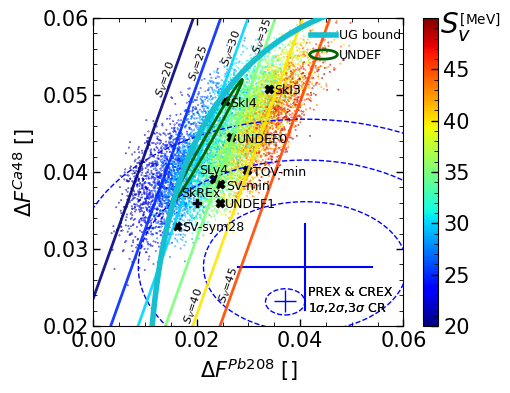

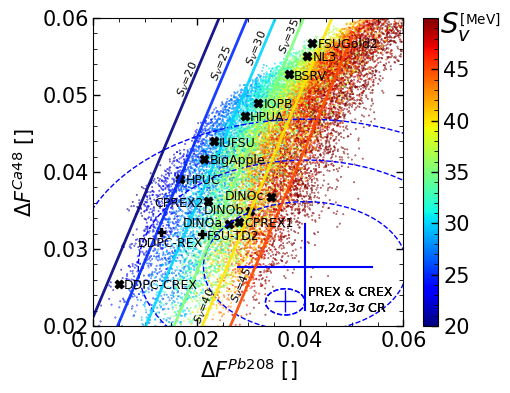

In [4]:

#for PrexCrex,BulK_J,name_model in zip([PrexCrex_Skyrme,PrexCrex_RMF_plot,PrexCrex_RMF_to_Skyrme_plot],[SAT_Skyrme[3],SAT_RMF_plot[3],SAT_RMF_to_Skyrme_plot[3]],['Skyrme','RMF','RMF_to_Skyrme']):
for PrexCrex,BulK_J,name_model in zip([PrexCrex_Skyrme,PrexCrex_RMF_plot],[SAT_Skyrme[3],SAT_RMF_plot[3]],['Skyrme','RMF']):
    FchFwCa=PrexCrex[0]-PrexCrex[2]
    FchFwPb=PrexCrex[1]-PrexCrex[3]
    
    logic_plot=np.full(BulK_J.shape,True)
    logic_fit=np.logical_and(BulK_J>19.9,BulK_J<49.9)

    fig,ax=plt.subplots(1,1,figsize=(5,4),sharex=False,sharey=False)
    ax.set_xlim(0,0.06)
    ax.set_ylim(0.02,0.06)

    Sv_center_array=np.linspace(20,45,6)
    FchFw_Pb_plot=np.linspace(0,0.05,51)

    #line=ax.plot([0.024,0.024],[0.026,0.039],'k')
    #line0=ax.plot([0.011,0.033],[0.034,0.034],'k',label='Ab initio')

    x=FchFwPb[logic_plot]
    y=FchFwCa[logic_plot]
    line3=ax.scatter(list(x)+[0], list(y)+[0], s=0.1, c=list(BulK_J[logic_plot])+[20], cmap='jet',vmin=20,vmax=50)
    cbar = fig.colorbar(line3, ax=ax,ticks=Sv_center_array)
    ax.text(0.067,0.058,'$S_v^{_{[\\rm{MeV}]}}$',fontsize=20)

    theta=np.linspace(0,2*np.pi,100)
    mean_208Pb=Fc_exp[1]-Fw_exp[1]
    mean_48Ca =Fc_exp[0]-Fw_exp[0]
    std_208Pb =np.sqrt(Fw_sig2[1])
    std_48Ca  =np.sqrt(Fw_sig2[0])
    ax.plot([mean_208Pb-std_208Pb,mean_208Pb+std_208Pb],[mean_48Ca,mean_48Ca],'-b')
    ax.plot([mean_208Pb,mean_208Pb],[mean_48Ca-std_48Ca,mean_48Ca+std_48Ca],'-b')
    import scipy.stats
    scale_chi2=scipy.stats.chi2.ppf(np.array([0.6827,0.9545,0.9973]),df=2)**0.5
    line5=ax.plot(mean_208Pb+scale_chi2[0]*std_208Pb*np.cos(theta),mean_48Ca+scale_chi2[0]*std_48Ca*np.sin(theta),'--b',lw=1,label='PREX & CREX\n1$\sigma$,2$\sigma$,3$\sigma$ CR')
    ax.plot(mean_208Pb+scale_chi2[1]*std_208Pb*np.cos(theta),mean_48Ca+scale_chi2[1]*std_48Ca*np.sin(theta),'--b',lw=1)
    ax.plot(mean_208Pb+scale_chi2[2]*std_208Pb*np.cos(theta),mean_48Ca+scale_chi2[2]*std_48Ca*np.sin(theta),'--b',lw=1)
    #ax.plot(mean_208Pb+scale_chi2[3]*std_208Pb*np.cos(theta),mean_48Ca+scale_chi2[3]*std_48Ca*np.sin(theta),lw=1,'--b')
    cross=ax.plot([],[],'b+',ms=16,label='PREX & CREX\n1$\sigma$,2$\sigma$,3$\sigma$ CR')
    ellipse=[ax.scatter([],[],linewidths=1,ls='--',marker=toolbox.ellipse_marker_fat,s=800,color=(1,1,1,0),edgecolor='b',label='PREX & CREX\n1$\sigma$,2$\sigma$,3$\sigma$ CR')]
    first_legend = ax.legend(handles=cross,fontsize=9,frameon=False, loc='lower right')
    ax.add_artist(first_legend)
    second_legend = ax.legend(handles=ellipse,fontsize=9,frameon=False, loc='lower right')
    ax.add_artist(second_legend)
    
    #ax.set_xlabel('$F_{ch}^{Pb208}-F_W^{Pb208}$ []',fontsize=15)
    #ax.set_ylabel('$F_{ch}^{Ca48}-F_W^{Ca48}$ []',fontsize=15)
    ax.set_xlabel('$\Delta F^{Pb208}$ []',fontsize=15)
    ax.set_ylabel('$\Delta F^{Ca48}$ []',fontsize=15)
    #ax.text(0.002,0.057,name_model,fontsize=15)

    def fit_Sv_check(FchFw_Pb_Sv,a,b,c):
        FchFw_Pb,Sv=FchFw_Pb_Sv
        return (Sv-b*FchFw_Pb-c)/a
    def fit_Sv_check2(FchFw_Ca_Sv,a,b,c):
        FchFw_Ca,Sv=FchFw_Ca_Sv
        return (Sv-a*FchFw_Ca-c)/b
    def fit_Sv(FchFw,a,b,c):
        FchFw_Ca,FchFw_Pb=FchFw
        return a*FchFw_Ca+b*FchFw_Pb+c
    fit_Sv_result,fit_Sv_error=opt.curve_fit(fit_Sv,[FchFwCa[logic_fit],FchFwPb[logic_fit]],BulK_J[logic_fit])
    print(name_model)
    print('a,b,c=',fit_Sv_result,np.sqrt(np.diag(fit_Sv_error)))
    print('Precision: ',100*np.std(fit_Sv([FchFwCa[logic_fit],FchFwPb[logic_fit]],*fit_Sv_result)/BulK_J[logic_fit]),'%')
    print('Precision: ',np.std(fit_Sv([FchFwCa[logic_fit],FchFwPb[logic_fit]],*fit_Sv_result)-BulK_J[logic_fit]),'MeV')

    cmap = matplotlib.colormaps.get_cmap('jet')
    rgba = cmap((Sv_center_array-20)/(50-20))
    for Sv_center,color_i,text_loc_y in zip(Sv_center_array,rgba,[0.05,0.052,0.054,0.0555,0.0205,0.0232]):
        FchFw_Ca_plot=fit_Sv_check([FchFw_Pb_plot,Sv_center+0*FchFw_Pb_plot],*fit_Sv_result)
        ax.plot(FchFw_Pb_plot,FchFw_Ca_plot,lw=2,alpha=0.9,color=color_i)
        ax.text((Sv_center-fit_Sv_result[0]*text_loc_y-fit_Sv_result[2])/fit_Sv_result[1]-0.0025,text_loc_y,'$S_V$=%d'%Sv_center,fontsize=8,rotation=180/np.pi*np.arctan(-1.5*fit_Sv_result[1]/fit_Sv_result[0]),color='k')
        #ax.text((Sv_center-fit_Sv_result[0]*text_loc_y-fit_Sv_result[2])/fit_Sv_result[1]-0.0025,text_loc_y,'$~~~~~$%d'%Sv_center,fontsize=8,rotation=180/np.pi*np.arctan(-1.5*fit_Sv_result[1]/fit_Sv_result[0]),color=color_i)
    try:
        if(name_model=='Skyrme'):
            line_UG=ax.plot(FchFw_PbCa_UG[1], FchFw_PbCa_UG[0], c='tab:cyan', lw=4,zorder=tews_zorder,label='UG bound')
            ax.plot(FchFw_PbCa_masses[1],FchFw_PbCa_masses[0],lw=2,color='darkgreen',label='UNDEF')
            line_mass=ax.plot([],[],ls='',marker=toolbox.ellipse_marker,ms=20,markeredgewidth=2,markeredgecolor='darkgreen',markerfacecolor=(1, 1, 1, 0),label='UNDEF')
            second_legend = ax.legend(handles=line_UG+line_mass,fontsize=9,frameon=False,handletextpad=0.3, loc='upper right', bbox_to_anchor=(1.03, 1))
            
            for x_lit,y_lit,name_lit in zip([0.0267,0.0245,0.0298,0.0246,0.0162,3.392011e-02,2.537884e-02],[0.0445,0.0360,0.0402,0.0384,0.0330,5.080275e-02,4.915386e-02],['UNDEF0','UNDEF1','TOV-min','SV-min','SV-sym28','SkI3','SkI4']):
                ax.scatter([x_lit],[y_lit],marker='X',c='k')
                ax.text(x_lit+0.001,y_lit-0.0007,name_lit,fontsize=9)
            for x_lit,y_lit,name_lit,marker in zip([0.0234,0.02],[0.0391,0.036],['SLy4','SkREx'],['X','P']):
                ax.scatter([x_lit],[y_lit],marker=marker,c='k')
                ax.text(x_lit-0.003,y_lit+0.0007,name_lit,fontsize=9)
        if(name_model=='RMF'):
            Pb208_DINO=list(np.array([0.4081,0.4081,0.4081])-np.array([0.3818,0.3778,0.3737]))
            Ca48_DINO =list(np.array([0.1602,0.1599,0.1592])-np.array([0.1269,0.1250,0.1225]))
            for x_lit,y_lit,name_lit in zip([0.0414,0.0233,0.0424,0.0319, 0.0215,0.0378,0.0293,0.0168,0.0049,0.0282],[0.0551,0.0440,0.0568,0.0490,0.0417,0.0527,0.0473,0.0391,0.0255,0.0335],['NL3','IUFSU','FSUGold2','IOPB','BigApple','BSRV','HPUA','HPUC','DDPC-CREX','CPREX1']):
                ax.scatter([x_lit],[y_lit],marker='X',c='k')
                ax.text(x_lit+0.001,y_lit-0.0007,name_lit,fontsize=9)
            for x_lit,y_lit,name_lit in zip(Pb208_DINO,Ca48_DINO,['DINOa','DINOb','DINOc']):
                ax.scatter([x_lit],[y_lit],marker='X',c='k')
                ax.text(x_lit-0.009,y_lit-0.0004,name_lit,fontsize=9)
            for x_lit,y_lit,name_lit in zip([0.0131],[0.0322],['DDPC-REX']):
                ax.scatter([x_lit],[y_lit],marker='P',c='k')
                ax.text(x_lit-0.0045,y_lit-0.002,name_lit,fontsize=9)
            for x_lit,y_lit,name_lit in zip([0.021],[0.0319],['FSU-TD2']):
                ax.scatter([x_lit],[y_lit],marker='P',c='k')
                ax.text(x_lit+0.001,y_lit-0.0007,name_lit,fontsize=9)
            x_lit,y_lit=[0.0222,0.0362]
            ax.scatter([x_lit],[y_lit],marker='X',c='k')
            ax.text(x_lit-0.0105,y_lit-0.0007,'CPREX2',fontsize=9)
    except:
        print('try failed. Maybe FchFw_PbCa_masses not defined yet.')
        pass
    plt.savefig('./figures/FF_Sv_'+name_model+'.pdf',bbox_inches = 'tight',format='pdf')
    plt.savefig('./figures/FF_Sv_'+name_model+'.png',bbox_inches = 'tight',format='png')


Skyrme
a,b,c= [1791.16521898 2652.03528358  -91.50211979] [27.20594561 19.03154168  0.90572546]
Precision:  821.4304328346009 %
Precision:  10.108477749412812
RMF
a,b,c= [2938.73372836 2420.6187724  -149.77347236] [43.53273969 33.94649156  1.44853764]
Precision:  4852.158634264002 %
Precision:  25.5606440235324


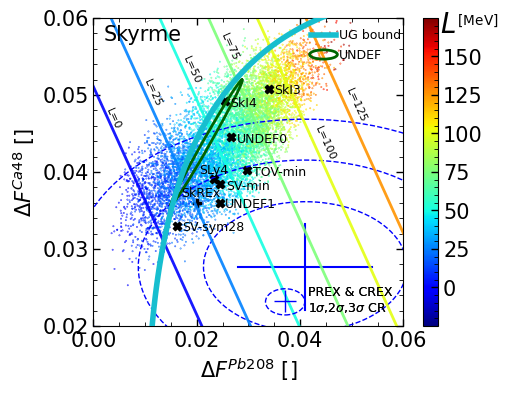

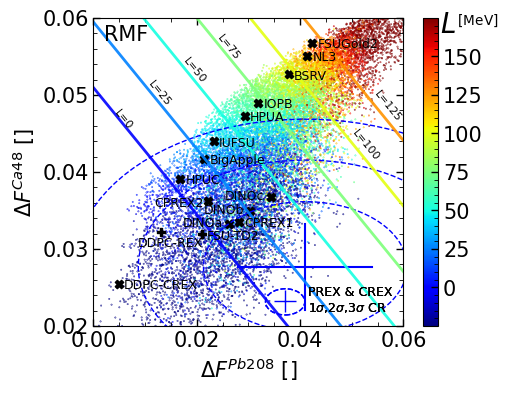

In [5]:
for PrexCrex,BulK_J,BulK_L,name_model in zip([PrexCrex_Skyrme,PrexCrex_RMF_plot],[SAT_Skyrme[3],SAT_RMF_plot[3]],[SAT_Skyrme[4],SAT_RMF_plot[4]],['Skyrme','RMF']):
    FchFwCa=PrexCrex[0]-PrexCrex[2]
    FchFwPb=PrexCrex[1]-PrexCrex[3]

    logic_plot=np.full(BulK_L.shape,True)
    logic_fit=np.logical_and(BulK_L>-5,BulK_L<185)

    fig,ax=plt.subplots(1,1,figsize=(5,4),sharex=False,sharey=False)
    ax.set_xlim(0,0.06)
    ax.set_ylim(0.02,0.06)
    #L_center_array=np.linspace(20,140,25)
    L_center_array=np.linspace(0,150,7)
    FchFw_Pb_plot=np.linspace(0,0.06,61)
    ax.text(0.002,0.057,name_model,fontsize=15)

    #line=ax.plot([0.024,0.024],[0.026,0.039],'k')
    #line0=ax.plot([0.011,0.033],[0.034,0.034],'k',label='Ab initio')
    x=FchFwPb[logic_plot]
    y=FchFwCa[logic_plot]
    line3=ax.scatter(x, y, s=0.1, c=BulK_L[logic_plot], cmap='jet', vmin=-25, vmax=175)
    cbar=fig.colorbar(line3, ax=ax,ticks=L_center_array)
    #cbar.ax.set_yticks(np.linspace(0,160,9))
    ax.text(0.067,0.058,'$L^{_{[\\rm{MeV}]}}$',fontsize=20)

    theta=np.linspace(0,2*np.pi,100)
    mean_208Pb=Fc_exp[1]-Fw_exp[1]
    mean_48Ca =Fc_exp[0]-Fw_exp[0]
    std_208Pb =np.sqrt(Fw_sig2[1])
    std_48Ca  =np.sqrt(Fw_sig2[0])
    ax.plot([mean_208Pb-std_208Pb,mean_208Pb+std_208Pb],[mean_48Ca,mean_48Ca],'-b')
    ax.plot([mean_208Pb,mean_208Pb],[mean_48Ca-std_48Ca,mean_48Ca+std_48Ca],'-b')
    import scipy.stats
    scale_chi2=scipy.stats.chi2.ppf(np.array([0.6827,0.9545,0.9973]),df=2)**0.5
    line5=ax.plot(mean_208Pb+scale_chi2[0]*std_208Pb*np.cos(theta),mean_48Ca+scale_chi2[0]*std_48Ca*np.sin(theta),'--b',lw=1,label='PREX & CREX\n1$\sigma$,2$\sigma$,3$\sigma$ CR')
    ax.plot(mean_208Pb+scale_chi2[1]*std_208Pb*np.cos(theta),mean_48Ca+scale_chi2[1]*std_48Ca*np.sin(theta),'--b',lw=1)
    ax.plot(mean_208Pb+scale_chi2[2]*std_208Pb*np.cos(theta),mean_48Ca+scale_chi2[2]*std_48Ca*np.sin(theta),'--b',lw=1)
    #ax.plot(mean_208Pb+scale_chi2[3]*std_208Pb*np.cos(theta),mean_48Ca+scale_chi2[3]*std_48Ca*np.sin(theta),lw=1,'--b')
    cross=ax.plot([],[],'b+',ms=16,label='PREX & CREX\n1$\sigma$,2$\sigma$,3$\sigma$ CR')
    ellipse=[ax.scatter([],[],linewidths=1,ls='--',marker=toolbox.ellipse_marker_fat,s=800,color=(1,1,1,0),edgecolor='b',label='PREX & CREX\n1$\sigma$,2$\sigma$,3$\sigma$ CR')]
    first_legend = ax.legend(handles=cross,fontsize=9,frameon=False, loc='lower right')
    ax.add_artist(first_legend)
    second_legend = ax.legend(handles=ellipse,fontsize=9,frameon=False, loc='lower right')
    ax.add_artist(second_legend)
    
    #ax.set_xlabel('$F_{ch}^{Pb208}-F_W^{Pb208}$ []',fontsize=15)
    #ax.set_ylabel('$F_{ch}^{Ca48}-F_W^{Ca48}$ []',fontsize=15)
    ax.set_xlabel('$\Delta F^{Pb208}$ []',fontsize=15)
    ax.set_ylabel('$\Delta F^{Ca48}$ []',fontsize=15)

    def fit_L_check(FchFw_Pb_L,a,b,c):
        FchFw_Pb,L=FchFw_Pb_L
        return (L-b*FchFw_Pb-c)/a
    def fit_L_check2(FchFw_Ca_L,a,b,c):
        FchFw_Ca,L=FchFw_Ca_L
        return (L-a*FchFw_Ca-c)/b
    def fit_L(FchFw,a,b,c):
        FchFw_Ca,FchFw_Pb=FchFw
        return a*FchFw_Ca+b*FchFw_Pb+c
    fit_L_result,fit_L_error=opt.curve_fit(fit_L,[FchFwCa[logic_fit],FchFwPb[logic_fit]],BulK_L[logic_fit],p0=[1,1,1])
    print(name_model)
    print('a,b,c=',fit_L_result,np.sqrt(np.diag(fit_L_error)))
    print('Precision: ',100*np.std(fit_L([FchFwCa[logic_fit],FchFwPb[logic_fit]],*fit_L_result)/BulK_L[logic_fit]),'%')
    print('Precision: ',np.std(fit_L([FchFwCa[logic_fit],FchFwPb[logic_fit]],*fit_L_result)-BulK_L[logic_fit]))

    cmap = matplotlib.colormaps.get_cmap('jet')
    rgba = cmap((L_center_array-(-25))/(175-(-25)))
    for L_center,color_i,text_loc_y in zip(L_center_array,rgba,[0.048,0.051,0.054,0.057,0.044,0.049]):
        FchFw_Ca_plot=fit_L_check([FchFw_Pb_plot,L_center+0*FchFw_Pb_plot],*fit_L_result)
        ax.plot(FchFw_Pb_plot,FchFw_Ca_plot,lw=2,alpha=0.9,color=color_i)
        ax.text((L_center-fit_L_result[0]*text_loc_y-fit_L_result[2])/fit_L_result[1],text_loc_y-0.0025,'L=%d'%L_center,fontsize=8,rotation=180/np.pi*np.arctan(-1.5*fit_L_result[1]/fit_L_result[0]),color='k')
    try:
        if(name_model=='Skyrme'):
            line_UG=ax.plot(FchFw_PbCa_UG[1], FchFw_PbCa_UG[0], c='tab:cyan', lw=4,zorder=tews_zorder,label='UG bound')
            ax.plot(FchFw_PbCa_masses[1],FchFw_PbCa_masses[0],lw=2,color='darkgreen',label='UNDEF')
            line_mass=ax.plot([],[],ls='',marker=toolbox.ellipse_marker,ms=20,markeredgewidth=2,markeredgecolor='darkgreen',markerfacecolor=(1, 1, 1, 0),label='UNDEF')
            second_legend = ax.legend(handles=line_UG+line_mass,fontsize=9,frameon=False,handletextpad=0.3, loc='upper right', bbox_to_anchor=(1.03, 1))
            for x_lit,y_lit,name_lit in zip([0.0267,0.0245,0.0298,0.0246,0.0162,3.392011e-02,2.537884e-02],[0.0445,0.0360,0.0402,0.0384,0.0330,5.080275e-02,4.915386e-02],['UNDEF0','UNDEF1','TOV-min','SV-min','SV-sym28','SkI3','SkI4']):
                ax.scatter([x_lit],[y_lit],marker='X',c='k')
                ax.text(x_lit+0.001,y_lit-0.0007,name_lit,fontsize=9)
            for x_lit,y_lit,name_lit,marker in zip([0.0234,0.02],[0.0391,0.036],['SLy4','SkREx'],['X','P']):
                ax.scatter([x_lit],[y_lit],marker=marker,c='k')
                ax.text(x_lit-0.003,y_lit+0.0007,name_lit,fontsize=9)
        if(name_model=='RMF'):
            Pb208_DINO=list(np.array([0.4081,0.4081,0.4081])-np.array([0.3818,0.3778,0.3737]))
            Ca48_DINO =list(np.array([0.1602,0.1599,0.1592])-np.array([0.1269,0.1250,0.1225]))
            for x_lit,y_lit,name_lit in zip([0.0414,0.0233,0.0424,0.0319, 0.0215,0.0378,0.0293,0.0168,0.0049,0.0282],[0.0551,0.0440,0.0568,0.0490,0.0417,0.0527,0.0473,0.0391,0.0255,0.0335],['NL3','IUFSU','FSUGold2','IOPB','BigApple','BSRV','HPUA','HPUC','DDPC-CREX','CPREX1']):
                ax.scatter([x_lit],[y_lit],marker='X',c='k')
                ax.text(x_lit+0.001,y_lit-0.0007,name_lit,fontsize=9)
            for x_lit,y_lit,name_lit in zip(Pb208_DINO,Ca48_DINO,['DINOa','DINOb','DINOc']):
                ax.scatter([x_lit],[y_lit],marker='X',c='k')
                ax.text(x_lit-0.009,y_lit-0.0004,name_lit,fontsize=9)
            for x_lit,y_lit,name_lit in zip([0.0131],[0.0322],['DDPC-REX']):
                ax.scatter([x_lit],[y_lit],marker='P',c='k')
                ax.text(x_lit-0.0045,y_lit-0.002,name_lit,fontsize=9)
            for x_lit,y_lit,name_lit in zip([0.021],[0.0319],['FSU-TD2']):
                ax.scatter([x_lit],[y_lit],marker='P',c='k')
                ax.text(x_lit+0.001,y_lit-0.0007,name_lit,fontsize=9)
            x_lit,y_lit=[0.0222,0.0362]
            ax.scatter([x_lit],[y_lit],marker='X',c='k')
            ax.text(x_lit-0.0105,y_lit-0.0007,'CPREX2',fontsize=9)
    except:
        pass
    plt.savefig('./figures/FF_L_'+name_model+'.pdf',bbox_inches = 'tight',format='pdf')
    plt.savefig('./figures/FF_L_'+name_model+'.png',bbox_inches = 'tight',format='png')

In [6]:
#Sv
Skyrme_Sv_fit=np.array([[-503.15403534,  945.22127475,   31.89221938], [7.82761983, 5.47575785, np.sqrt(0.26055098**2+2.907991479720574**2)]])
RMF_Sv_fit   =np.array([[-575.16334707,  916.25267173,   32.21119673], [5.11908268, 4.57687047,  np.sqrt(0.1362248**2+3.7078478498636382**2)]])
#L
Skyrme_L_fit=np.array([[1791.16521898, 2652.03528358,  -91.50211979], [27.20594561, 19.03154168,  np.sqrt(0.90572546**2+10.108477749412812**2)]])
RMF_L_fit   =np.array([[2938.73372836, 2420.6187724,  -149.77347236], [43.53273969, 33.94649156,  np.sqrt(1.44853764**2+25.5606440235324**2)]])
for name,Sv_fit,L_fit in zip(['RMF','Skyrme'],[RMF_Sv_fit,Skyrme_Sv_fit],[RMF_L_fit,Skyrme_L_fit]):
    text=''
    for i in range(3):
        text+='$%.1f \pm %.1f$ & '%tuple(Sv_fit[:,i])
    for i in range(3):
        text+='$%.1f \pm %.1f$ & '%tuple(L_fit[:,i])
    print(name+' & '+text[:-3]+'\\\\')

RMF & $-575.2 \pm 5.1$ & $916.3 \pm 4.6$ & $32.2 \pm 3.7$ & $2938.7 \pm 43.5$ & $2420.6 \pm 33.9$ & $-149.8 \pm 25.6$\\
Skyrme & $-503.2 \pm 7.8$ & $945.2 \pm 5.5$ & $31.9 \pm 2.9$ & $1791.2 \pm 27.2$ & $2652.0 \pm 19.0$ & $-91.5 \pm 10.1$\\


In [7]:
for Sv_fit,L_fit in zip([Skyrme_Sv_fit,RMF_Sv_fit],[Skyrme_L_fit,RMF_L_fit]):
    mean=Sv_fit[0][0]*mean_48Ca+Sv_fit[0][1]*mean_208Pb+Sv_fit[0][2],L_fit[0][0]*mean_48Ca+L_fit[0][1]*mean_208Pb+L_fit[0][2]
    print('mean of (Sv,L): ',mean)
    cov =[[Sv_fit[0][0]**2*std_48Ca**2+Sv_fit[0][1]**2*std_208Pb**2+Sv_fit[1][2]**2,Sv_fit[0][0]*L_fit[0][0]*std_48Ca**2+Sv_fit[0][1]*L_fit[0][1]*std_208Pb**2+Sv_fit[1][2]*L_fit[1][2]]]
    cov+=[[Sv_fit[0][0]*L_fit[0][0]*std_48Ca**2+Sv_fit[0][1]*L_fit[0][1]*std_208Pb**2+Sv_fit[1][2]*L_fit[1][2],L_fit[0][0]**2*std_48Ca**2+L_fit[0][1]**2*std_208Pb**2+L_fit[1][2]**2]]
    print('cov of (Sv,L): ',np.round((np.array(cov))**0.5*scale_chi2[0],decimals=1))
    print()

mean of (Sv,L):  (56.70892486583199, 66.84660340252594)
cov of (Sv,L):  [[19.6 31.2]
 [31.2 56.5]]

mean of (Sv,L):  (53.84553155709098, 30.874821583971965)
cov of (Sv,L):  [[19.5 31. ]
 [31.  66.3]]



Skyrme
a,b,c= [-52.02671976  27.81125065   1.66822418] [0.42319912 0.29158414 0.01388602]
Precision:  3981.5006830762422 %
Precision:  0.14773683422749295
RMF
a,b,c= [-31.84547161  23.52842124   0.93691377] [0.16608828 0.13426713 0.00434278]
Precision:  104.29810510082437 %
Precision:  0.11142603335932409


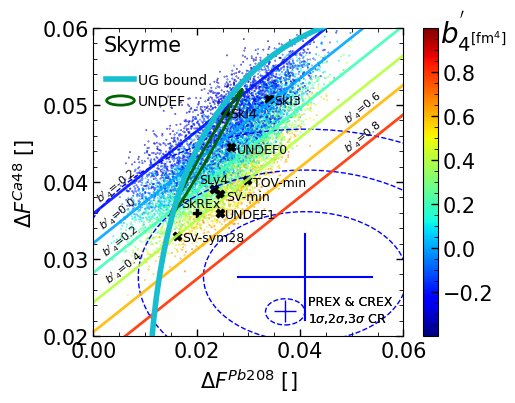

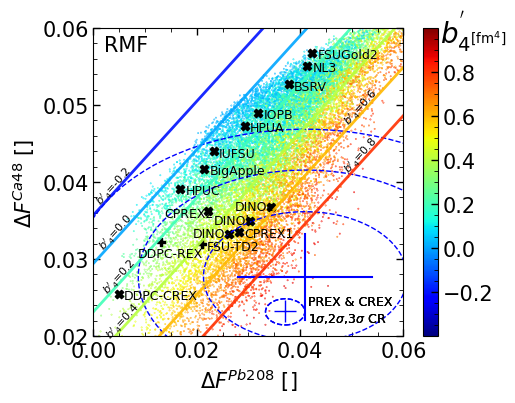

In [8]:

# FchFwCa=np.concatenate((PrexCrex[0]-PrexCrex[2],[0,0]))
# FchFwPb=np.concatenate((PrexCrex[1]-PrexCrex[3],[0,0]))
# BulK_L=np.concatenate((eos_args_Skyrme[10],[-0.4,1]))
# name_model='Skyrme'

# FchFwCa=np.concatenate(((PrexCrex_RMF[0]-PrexCrex_RMF[2])[logic_FcRqBE_basic_toplot],[0,0]))
# FchFwPb=np.concatenate(((PrexCrex_RMF[1]-PrexCrex_RMF[3])[logic_FcRqBE_basic_toplot],[0,0]))
# BulK_L=np.concatenate((((eos_args_RMF[4]/763**2+eos_args_RMF[2]/980**2)/(8*939**2)*197.3**4)[logic_FcRqBE_basic_toplot],[-0.4,1]))
# name_model='RMF'
for PrexCrex,BulK_L,name_model in zip([PrexCrex_Skyrme,PrexCrex_RMF_plot],[eos_args_Skyrme[10],(eos_args_RMF_plot[4]/763**2+eos_args_RMF_plot[2]/980**2)/(8*939**2)*197.3**4],['Skyrme','RMF']):
    FchFwCa=np.concatenate((PrexCrex[0]-PrexCrex[2],[0,0]))
    FchFwPb=np.concatenate((PrexCrex[1]-PrexCrex[3],[0,0]))
    BulK_L=np.concatenate((BulK_L,[-0.4,1]))
    
    logic_plot=np.full(BulK_L.shape,True)
    logic_fit=np.logical_and(BulK_L>-0.3,BulK_L<0.7)

    fig,ax=plt.subplots(1,1,figsize=(5,4),sharex=False,sharey=False)
    ax.set_xlim(0,0.06)
    ax.set_ylim(0.02,0.06)
    L_center_array=np.linspace(-0.2,0.8,6)
    FchFw_Pb_plot=np.linspace(0,0.06,61)
    ax.text(0.002,0.057,name_model,fontsize=15)

    #line=ax.plot([0.024,0.024],[0.026,0.039],'k')
    #line0=ax.plot([0.011,0.033],[0.034,0.034],'k',label='Ab initio')
    x=FchFwPb[logic_plot]
    y=FchFwCa[logic_plot]
    line3=ax.scatter(list(x)+[0,0], list(y)+[0,0], s=0.1, c=list(BulK_L[logic_plot])+[-0.3,0.9], cmap='jet')
    cbar=fig.colorbar(line3, ax=ax,ticks=L_center_array)
    #cbar.ax.set_yticks(np.linspace(0,160,9))
    ax.text(0.067,0.058,'$b^{\'}_{4^{[\\rm{fm}^4]}}$',fontsize=20)

    theta=np.linspace(0,2*np.pi,100)
    mean_208Pb=Fc_exp[1]-Fw_exp[1]
    mean_48Ca =Fc_exp[0]-Fw_exp[0]
    std_208Pb =np.sqrt(Fw_sig2[1])
    std_48Ca  =np.sqrt(Fw_sig2[0])
    ax.plot([mean_208Pb-std_208Pb,mean_208Pb+std_208Pb],[mean_48Ca,mean_48Ca],'-b')
    ax.plot([mean_208Pb,mean_208Pb],[mean_48Ca-std_48Ca,mean_48Ca+std_48Ca],'-b')
    import scipy.stats
    scale_chi2=scipy.stats.chi2.ppf(np.array([0.6827,0.9545,0.9973]),df=2)**0.5
    line5=ax.plot(mean_208Pb+scale_chi2[0]*std_208Pb*np.cos(theta),mean_48Ca+scale_chi2[0]*std_48Ca*np.sin(theta),'--b',lw=1,label='PREX & CREX\n1$\sigma$,2$\sigma$,3$\sigma$ CR')
    ax.plot(mean_208Pb+scale_chi2[1]*std_208Pb*np.cos(theta),mean_48Ca+scale_chi2[1]*std_48Ca*np.sin(theta),'--b',lw=1)
    ax.plot(mean_208Pb+scale_chi2[2]*std_208Pb*np.cos(theta),mean_48Ca+scale_chi2[2]*std_48Ca*np.sin(theta),'--b',lw=1)
    #ax.plot(mean_208Pb+scale_chi2[3]*std_208Pb*np.cos(theta),mean_48Ca+scale_chi2[3]*std_48Ca*np.sin(theta),lw=1,'--b')
    cross=ax.plot([],[],'b+',ms=16,label='PREX & CREX\n1$\sigma$,2$\sigma$,3$\sigma$ CR')
    ellipse=[ax.scatter([],[],linewidths=1,ls='--',marker=toolbox.ellipse_marker_fat,s=800,color=(1,1,1,0),edgecolor='b',label='PREX & CREX\n1$\sigma$,2$\sigma$,3$\sigma$ CR')]
    first_legend = ax.legend(handles=cross,fontsize=9,frameon=False, loc='lower right')
    ax.add_artist(first_legend)
    second_legend = ax.legend(handles=ellipse,fontsize=9,frameon=False, loc='lower right')
    ax.add_artist(second_legend)
    
    #ax.set_xlabel('$F_{ch}^{Pb208}-F_W^{Pb208}$ []',fontsize=15)
    #ax.set_ylabel('$F_{ch}^{Ca48}-F_W^{Ca48}$ []',fontsize=15)
    ax.set_xlabel('$\Delta F^{Pb208}$ []',fontsize=15)
    ax.set_ylabel('$\Delta F^{Ca48}$ []',fontsize=15)

    def fit_L_check(FchFw_Pb_L,a,b,c):
        FchFw_Pb,L=FchFw_Pb_L
        return (L-b*FchFw_Pb-c)/a
    def fit_L_check2(FchFw_Ca_L,a,b,c):
        FchFw_Ca,L=FchFw_Ca_L
        return (L-a*FchFw_Ca-c)/b
    def fit_L(FchFw,a,b,c):
        FchFw_Ca,FchFw_Pb=FchFw
        return a*FchFw_Ca+b*FchFw_Pb+c
    fit_L_result,fit_L_error=opt.curve_fit(fit_L,[FchFwCa[logic_fit],FchFwPb[logic_fit]],BulK_L[logic_fit],p0=[1,1,1])
    fit_L_result_std=np.sqrt(np.diag(fit_L_error))
    print(name_model)
    print('a,b,c=',fit_L_result,fit_L_result_std)
    print('Precision: ',100*np.std(fit_L([FchFwCa[logic_fit],FchFwPb[logic_fit]],*fit_L_result)/BulK_L[logic_fit]),'%')
    print('Precision: ',np.std(fit_L([FchFwCa[logic_fit],FchFwPb[logic_fit]],*fit_L_result)-BulK_L[logic_fit]))
    fit_L_result_std[2]=np.sqrt(fit_L_result_std[2]**2+(np.std(fit_L([FchFwCa[logic_fit],FchFwPb[logic_fit]],*fit_L_result)-BulK_L[logic_fit]))**2)
    
    cmap = matplotlib.colormaps.get_cmap('jet')
    rgba = cmap((L_center_array-BulK_L[logic_plot].min())/(BulK_L[logic_plot].max()-BulK_L[logic_plot].min()))
    for L_center,color_i,text_loc_x in zip(L_center_array,rgba,[0,0.0006,0.0012,0.0018,0.048,0.048]):
        FchFw_Ca_plot=fit_L_check([FchFw_Pb_plot,L_center+0*FchFw_Pb_plot],*fit_L_result)
        ax.plot(FchFw_Pb_plot,FchFw_Ca_plot,lw=2,alpha=0.9,color=color_i)
        ax.text(text_loc_x,(L_center-fit_L_result[1]*text_loc_x-fit_L_result[2])/fit_L_result[0]+0.0015,'$b\'_4$=%.1f'%L_center,fontsize=8,rotation=180/np.pi*np.arctan(-1.5*fit_L_result[1]/fit_L_result[0]),color='k')
    try:
        if(name_model=='Skyrme'):
            line_UG=ax.plot(FchFw_PbCa_UG[1], FchFw_PbCa_UG[0], c='tab:cyan', lw=4,zorder=tews_zorder,label='UG bound')
            ax.plot(FchFw_PbCa_masses[1],FchFw_PbCa_masses[0],lw=2,color='darkgreen',label='UNDEF')
            line_mass=ax.plot([],[],ls='',marker=toolbox.ellipse_marker,ms=20,markeredgewidth=2,markeredgecolor='darkgreen',markerfacecolor=(1, 1, 1, 0),label='UNDEF')
            second_legend = ax.legend(handles=line_UG+line_mass,fontsize=10,frameon=False,handletextpad=0.3, loc='lower left', bbox_to_anchor=(0, 0.7))
            for x_lit,y_lit,name_lit in zip([0.0267,0.0245,0.0298,0.0246,0.0162,3.392011e-02,2.537884e-02],[0.0445,0.0360,0.0402,0.0384,0.0330,5.080275e-02,4.915386e-02],['UNDEF0','UNDEF1','TOV-min','SV-min','SV-sym28','SkI3','SkI4']):
                ax.scatter([x_lit],[y_lit],marker='X',c='k')
                ax.text(x_lit+0.001,y_lit-0.0007,name_lit,fontsize=9)
            for x_lit,y_lit,name_lit,marker in zip([0.0234,0.02],[0.0391,0.036],['SLy4','SkREx'],['X','P']):
                ax.scatter([x_lit],[y_lit],marker=marker,c='k')
                ax.text(x_lit-0.003,y_lit+0.0007,name_lit,fontsize=9)
            Skyrme_b4_fit=np.array([fit_L_result,fit_L_result_std])
        if(name_model=='RMF'):
            Pb208_DINO=list(np.array([0.4081,0.4081,0.4081])-np.array([0.3818,0.3778,0.3737]))
            Ca48_DINO =list(np.array([0.1602,0.1599,0.1592])-np.array([0.1269,0.1250,0.1225]))
            for x_lit,y_lit,name_lit in zip([0.0414,0.0233,0.0424,0.0319, 0.0215,0.0378,0.0293,0.0168,0.0049,0.0282],[0.0551,0.0440,0.0568,0.0490,0.0417,0.0527,0.0473,0.0391,0.0255,0.0335],['NL3','IUFSU','FSUGold2','IOPB','BigApple','BSRV','HPUA','HPUC','DDPC-CREX','CPREX1']):
                ax.scatter([x_lit],[y_lit],marker='X',c='k')
                ax.text(x_lit+0.001,y_lit-0.0007,name_lit,fontsize=9)
            for x_lit,y_lit,name_lit in zip(Pb208_DINO,Ca48_DINO,['DINOa','DINOb','DINOc']):
                ax.scatter([x_lit],[y_lit],marker='X',c='k')
                ax.text(x_lit-0.007,y_lit-0.0004,name_lit,fontsize=9)
            for x_lit,y_lit,name_lit in zip([0.0131],[0.0322],['DDPC-REX']):
                ax.scatter([x_lit],[y_lit],marker='P',c='k')
                ax.text(x_lit-0.0045,y_lit-0.002,name_lit,fontsize=9)
            for x_lit,y_lit,name_lit in zip([0.021],[0.0319],['FSU-TD2']):
                ax.scatter([x_lit],[y_lit],marker='P',c='k')
                ax.text(x_lit+0.001,y_lit-0.0007,name_lit,fontsize=9)
            x_lit,y_lit=[0.0222,0.0362]
            ax.scatter([x_lit],[y_lit],marker='X',c='k')
            ax.text(x_lit-0.0085,y_lit-0.0007,'CPREX2',fontsize=9)
    except:
        pass
    plt.savefig('./figures/FF_b4p_'+name_model+'.pdf',bbox_inches = 'tight',format='pdf')
    plt.savefig('./figures/FF_b4p_'+name_model+'.png',bbox_inches = 'tight',format='png')

In [9]:
Skyrme_b4_fit=np.array([[-52.02671976,  27.81125065,   1.66822418], [0.42319912, 0.29158414, np.sqrt(0.01388602**2+0.14773683422749295**2)]])
RMF_b4_fit   =np.array([[-31.84547161,  23.52842124,   0.93691377], [0.16608828, 0.13426713, np.sqrt(0.00434278**2+0.11142603335932409**2)]])
for name,Sv_fit,L_fit,b4_fit in zip(['RMF','Skyrme'],[RMF_Sv_fit,Skyrme_Sv_fit],[RMF_L_fit,Skyrme_L_fit],[RMF_b4_fit,Skyrme_b4_fit]):
    text=''
    for i in range(3):
        text+='$%.1f \pm %.1f$ & '%tuple(Sv_fit[:,i])
    for i in range(3):
        text+='$%.1f \pm %.1f$ & '%tuple(L_fit[:,i])
    for i in range(3):
        if(i==2):
            text+='$%.2f \pm %.2f$ & '%tuple(b4_fit[:,i])
        else:
            text+='$%.1f \pm %.1f$ & '%tuple(b4_fit[:,i])
    print(name+' & '+text[:-3]+'\\\\')

RMF & $-575.2 \pm 5.1$ & $916.3 \pm 4.6$ & $32.2 \pm 3.7$ & $2938.7 \pm 43.5$ & $2420.6 \pm 33.9$ & $-149.8 \pm 25.6$ & $-31.8 \pm 0.2$ & $23.5 \pm 0.1$ & $0.94 \pm 0.11$\\
Skyrme & $-503.2 \pm 7.8$ & $945.2 \pm 5.5$ & $31.9 \pm 2.9$ & $1791.2 \pm 27.2$ & $2652.0 \pm 19.0$ & $-91.5 \pm 10.1$ & $-52.0 \pm 0.4$ & $27.8 \pm 0.3$ & $1.67 \pm 0.15$\\


In [10]:
for b4_fit,b4_fit_std in zip([RMF_b4_fit[0],Skyrme_b4_fit[0]],[RMF_b4_fit[1],Skyrme_b4_fit[1]]):
    # mean of b'4
    mean=b4_fit[0]*mean_48Ca+b4_fit[1]*mean_208Pb+b4_fit[2]
    # std of b'4
    std=np.sqrt((b4_fit[0]*std_48Ca)**2+(b4_fit[1]*std_208Pb)**2+b4_fit_std[2]**2)
    #print((b4_fit[0]*std_48Ca)**2+(b4_fit[1]*std_208Pb)**2,b4_fit_std[2]**2)
    print('mean=',mean,'; std=',std)
    print('90% lower bound: ',mean-1.28155157*std)
    print('90% lower bound g_delta**2+(g_rho*m_delta/m_rho)**2: ',(mean-1.28155157*std)*(8*939**2)/197.3**4*980**2)

print('(m_delta/m_rho)**2=',(980/763)**2)

mean= 1.0194594772429995 ; std= 0.3707687666952142
90% lower bound:  0.544300182177784
90% lower bound g_delta**2+(g_rho*m_delta/m_rho)**2:  2433.343733426997
mean= 1.3673453192979994 ; std= 0.48657283993201733
90% lower bound:  0.7437771323637639
90% lower bound g_delta**2+(g_rho*m_delta/m_rho)**2:  3325.1236787433468
(m_delta/m_rho)**2= 1.6496927868024578


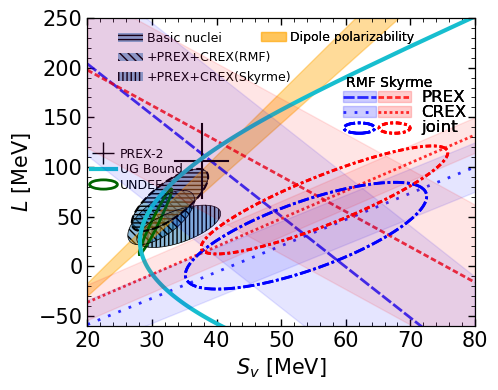

In [11]:

fig,ax=plt.subplots(1,1,figsize=(5,4),sharex=False,sharey=False)
ax_twin=ax.twinx()

name_model='RMF'
fit_Sv_result=RMF_Sv_fit[0]
fit_L_result =RMF_L_fit[0]

#ax.scatter(BulK_J,BulK_L,marker='<',s=0.05,color='b')
Sv_plot=np.linspace(20,80,61)
L_plot_list_208Pb=[]
L_plot_list_48Ca =[]
for j in [-1,0,1]:
    L_plot=fit_L([fit_Sv_check([mean_208Pb+j*std_208Pb,Sv_plot],*fit_Sv_result),mean_208Pb+j*std_208Pb],*fit_L_result)
    L_plot_list_208Pb.append(L_plot)

    L_plot=fit_L([mean_48Ca+j*std_48Ca,fit_Sv_check2([mean_48Ca+j*std_48Ca,Sv_plot],*fit_Sv_result)],*fit_L_result)
    L_plot_list_48Ca.append(L_plot)
list_RMF=ax.plot(Sv_plot,L_plot_list_208Pb[1],lw=2,ls=(0, (4, 1)),color='b',alpha=0.8,label=' ')
list_RMF+=ax.plot(Sv_plot,L_plot_list_48Ca[1],lw=2,ls=(0, (1, 3)),color='b',alpha=0.8,label=' ')
list_RMF_twin=[]
list_RMF_twin.append(ax_twin.fill_between(Sv_plot,L_plot_list_208Pb[0],L_plot_list_208Pb[2],color='b',alpha=0.1,label=' '))
list_RMF_twin.append(ax_twin.fill_between(Sv_plot,L_plot_list_48Ca[0],L_plot_list_48Ca[2],color='b',alpha=0.1,label=' '))

for i,label in enumerate([name_model]):
    L_plot=fit_L(np.array([mean_48Ca+scale_chi2[i]*std_48Ca*np.sin(theta),mean_208Pb+scale_chi2[i]*std_208Pb*np.cos(theta)]),*fit_L_result)
    Sv_plot=fit_Sv(np.array([mean_48Ca+scale_chi2[i]*std_48Ca*np.sin(theta),mean_208Pb+scale_chi2[i]*std_208Pb*np.cos(theta)]),*fit_Sv_result)
    ax.plot(Sv_plot,L_plot,lw=2,ls=(0, (4, 1, 1, 1)),color='b',label=' ')
    ax_twin.plot(Sv_plot,L_plot,lw=2,ls=(0, (4, 1, 1, 1)),color='b',label=' ')
    list_RMF+=[ax.scatter([],[],linewidths=2,ls=(0, (4, 1, 1, 1)),marker=toolbox.ellipse_marker,s=500,color=(1,1,1,0),edgecolor='b',label=' ')]
    list_RMF_twin+=[ax.scatter([],[],linewidths=2,ls=(0, (4, 1, 1, 1)),marker=toolbox.ellipse_marker,s=500,color=(1,1,1,0),edgecolor='b',label=' ')]

name_model='Skyrme'
fit_Sv_result=Skyrme_Sv_fit[0]
fit_L_result =Skyrme_L_fit[0]

#ax.scatter(BulK_J,BulK_L,marker='<',s=0.1,color='r')
Sv_plot=np.linspace(20,80,61)
L_plot_list_208Pb=[]
L_plot_list_48Ca =[]
for j in [-1,0,1]:
    L_plot=fit_L([fit_Sv_check([mean_208Pb+j*std_208Pb,Sv_plot],*fit_Sv_result),mean_208Pb+j*std_208Pb],*fit_L_result)
    L_plot_list_208Pb.append(L_plot)

    L_plot=fit_L([mean_48Ca+j*std_48Ca,fit_Sv_check2([mean_48Ca+j*std_48Ca,Sv_plot],*fit_Sv_result)],*fit_L_result)
    L_plot_list_48Ca.append(L_plot)
list_Skyrme =ax.plot(Sv_plot,L_plot_list_208Pb[1],lw=2,ls=(0, (2, 1)),color='r',alpha=0.8,label='PREX')
list_Skyrme+=ax.plot(Sv_plot,L_plot_list_48Ca[1],lw=2,ls=(0, (1, 1)),color='r',alpha=0.8,label='CREX')
list_Skyrme_twin=[]
list_Skyrme_twin.append(ax_twin.fill_between(Sv_plot,L_plot_list_208Pb[0],L_plot_list_208Pb[2],color='r',alpha=0.1,label='PREX'))
list_Skyrme_twin.append(ax_twin.fill_between(Sv_plot,L_plot_list_48Ca[0],L_plot_list_48Ca[2],color='r',alpha=0.1,label='CREX'))

for i,label in enumerate([name_model]):
    L_plot=fit_L(np.array([mean_48Ca+scale_chi2[i]*std_48Ca*np.sin(theta),mean_208Pb+scale_chi2[i]*std_208Pb*np.cos(theta)]),*fit_L_result)
    Sv_plot=fit_Sv(np.array([mean_48Ca+scale_chi2[i]*std_48Ca*np.sin(theta),mean_208Pb+scale_chi2[i]*std_208Pb*np.cos(theta)]),*fit_Sv_result)
    ax.plot(Sv_plot,L_plot,lw=2,ls=(0, (2, 1, 1, 1)),color='r',label='joint')
    ax_twin.plot(Sv_plot,L_plot,lw=2,ls=(0, (2, 1, 1, 1)),color='r',label='joint')
    list_Skyrme+=[ax.scatter([],[],linewidths=2,ls=(0, (2, 1, 1, 1)),marker=toolbox.ellipse_marker,s=500,color=(1,1,1,0),edgecolor='r',label='joint')]
    list_Skyrme_twin+=[ax.scatter([],[],linewidths=2,ls=(0, (2, 1, 1, 1)),marker=toolbox.ellipse_marker,s=500,color=(1,1,1,0),edgecolor='r',label='joint')]

first_legend = ax.legend(title='RMF Skyrme       ',handles=list_RMF+list_Skyrme,fontsize=12,frameon=False,handletextpad=0.6,ncol=2,columnspacing=-0.8,labelspacing=0, loc='lower left', bbox_to_anchor=(0.62, 0.57))
ax.add_artist(first_legend)
ax.set_xlim(20,80)
ax.set_ylim(-60,250) 
ax.set_xlabel('$S_v$ [MeV]',fontsize=15)
ax.set_ylabel('$L$ [MeV]',fontsize=15)

first_legend = ax_twin.legend(title='RMF Skyrme       ',handles=list_RMF_twin+list_Skyrme_twin,fontsize=12,frameon=False,handletextpad=0.6,ncol=2,columnspacing=-0.8,labelspacing=0, loc='lower left', bbox_to_anchor=(0.62, 0.57))
ax_twin.add_artist(first_legend)
ax_twin.set_xlim(20,80)
ax_twin.set_ylim(-60,250)
ax_twin.set_yticklabels('')

#ax.axvspan(30,32,color='grey',alpha=0.3)
ax.plot(np.array(data_SvL_masses['Esym']),np.array(data_SvL_masses['L']),lw=2,color='darkgreen')
line_mass=ax.plot([],[],ls='',marker=toolbox.ellipse_marker,ms=20,markeredgewidth=2,markeredgecolor='darkgreen',markerfacecolor=(1, 1, 1, 0),label='UNDEF')

line_UG=ax.plot(Esym_tews, L_tews, c='tab:cyan', lw=3,zorder=tews_zorder,label='UG Bound')
ax.plot([37.7,37.7],[106-37,106+37],'k')
ax.plot([37.7-4.1,37.7+4.1],[106,106],'k')
line_prex2=ax.plot([],[],'k+',ms=16,label='PREX-2')

mean,cov=[[34.1403562, 40.3024777],[[ 42.19991969,  83.52975473],[ 83.52975473, 453.23480257]]]
width, height, angle=cov_ellipse(cov)
x,y=cov_ellipse_xy(mean,cov)
ax.plot(x,y,'k',lw=0.5)
Skyrme_SvL=matplotlib.patches.Ellipse(mean, 2*width, 2*height, angle=180/np.pi*angle,hatch='||||',color=None,alpha=0.5,label='+PREX+CREX(Skyrme)')
ax.add_artist(Skyrme_SvL)

mean,cov=[[31.42158453, 49.13189107],[[ 26.71305169,  92.79344187],[ 92.79344187, 749.8499721 ]]]
width, height, angle=cov_ellipse(cov)
x,y=cov_ellipse_xy(mean,cov)
ax.plot(x,y,'k',lw=0.5)
RMF_SvL=matplotlib.patches.Ellipse(mean, 2*width, 2*height, angle=180/np.pi*angle,hatch='\\\\\\\\',color=None,alpha=0.5,label='+PREX+CREX(RMF)')
ax.add_artist(RMF_SvL)

mean,cov=[[32.77900096, 66.82662838],[[ 34.96167206, 136.75320432],[136.75320432, 976.4023266 ]]]
width, height, angle=cov_ellipse(cov)
x,y=cov_ellipse_xy(mean,cov)
ax.plot(x,y,'k',lw=0.5)
prior_SvL=matplotlib.patches.Ellipse(mean, 2*width, 2*height, angle=180/np.pi*angle,hatch='----',color=None,alpha=0.5,label='Basic nuclei')
ax.add_artist(prior_SvL)

nuclei_SvL=ax.plot(x,y,'--k',label='Basic Nuclei')
# #nuclei_SvL_joint=ax.plot(x,y,'-.k',label='+PREX+CREX')

second_legend = ax.legend(handles=[prior_SvL,RMF_SvL,Skyrme_SvL],fontsize=9,frameon=False,handletextpad=0.3, loc='lower left', bbox_to_anchor=(0.05, 0.75),ncols=1)
ax.add_artist(second_legend)

second_legend = ax.legend(handles=line_prex2+line_UG+line_mass,fontsize=9,frameon=False,handletextpad=0.3,labelspacing=0.2, loc='lower left', bbox_to_anchor=(-0.02, 0.4),ncols=1)
ax.add_artist(second_legend)

Sv_plot=np.linspace(20,80,61)
band_dipole=[ax.fill_between(Sv_plot,6.11*Sv_plot-146-(0.1*Sv_plot**2+1)**0.5,6.11*Sv_plot-146+(0.1*Sv_plot**2+1)**0.5,color='orange',alpha=0.4,label='Dipole polarizability')]
second_legend = ax.legend(handles=band_dipole,fontsize=9,frameon=False,handletextpad=0.3, loc='lower left', bbox_to_anchor=(0.42, 0.88),ncols=1)
ax.add_artist(second_legend)

#plot_covariance([34.1403562, 40.3024777],[[ 42.19991969,  83.52975473],[ 83.52975473, 453.23480257]],ax=ax)
#plot_covariance([31.42158453, 49.13189107], [[ 26.71305169,  92.79344187],[ 92.79344187, 749.8499721 ]],ax=ax)

plt.savefig('./figures/Sv_L_PREX_CREX.pdf',bbox_inches = 'tight',format='pdf')


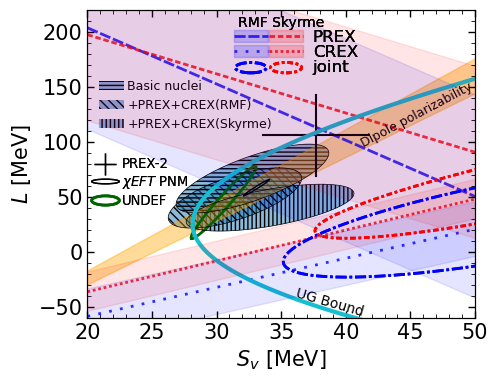

In [12]:

fig,ax=plt.subplots(1,1,figsize=(5,4),sharex=False,sharey=False)
ax_twin=ax.twinx()

name_model='RMF'
fit_Sv_result=RMF_Sv_fit[0]
fit_L_result =RMF_L_fit[0]

#ax.scatter(BulK_J,BulK_L,marker='<',s=0.05,color='b')
Sv_plot=np.linspace(20,80,61)
L_plot_list_208Pb=[]
L_plot_list_48Ca =[]
for j in [-1,0,1]:
    L_plot=fit_L([fit_Sv_check([mean_208Pb+j*std_208Pb,Sv_plot],*fit_Sv_result),mean_208Pb+j*std_208Pb],*fit_L_result)
    L_plot_list_208Pb.append(L_plot)

    L_plot=fit_L([mean_48Ca+j*std_48Ca,fit_Sv_check2([mean_48Ca+j*std_48Ca,Sv_plot],*fit_Sv_result)],*fit_L_result)
    L_plot_list_48Ca.append(L_plot)
list_RMF=ax.plot(Sv_plot,L_plot_list_208Pb[1],lw=2,ls=(0, (4, 1)),color='b',alpha=0.8,label=' ')
list_RMF+=ax.plot(Sv_plot,L_plot_list_48Ca[1],lw=2,ls=(0, (1, 3)),color='b',alpha=0.8,label=' ')
list_RMF_twin=[]
list_RMF_twin.append(ax_twin.fill_between(Sv_plot,L_plot_list_208Pb[0],L_plot_list_208Pb[2],color='b',alpha=0.1,label=' '))
list_RMF_twin.append(ax_twin.fill_between(Sv_plot,L_plot_list_48Ca[0],L_plot_list_48Ca[2],color='b',alpha=0.1,label=' '))

for i,label in enumerate([name_model]):
    L_plot=fit_L(np.array([mean_48Ca+scale_chi2[i]*std_48Ca*np.sin(theta),mean_208Pb+scale_chi2[i]*std_208Pb*np.cos(theta)]),*fit_L_result)
    Sv_plot=fit_Sv(np.array([mean_48Ca+scale_chi2[i]*std_48Ca*np.sin(theta),mean_208Pb+scale_chi2[i]*std_208Pb*np.cos(theta)]),*fit_Sv_result)
    ax.plot(Sv_plot,L_plot,lw=2,ls=(0, (4, 1, 1, 1)),color='b',label=' ')
    ax_twin.plot(Sv_plot,L_plot,lw=2,ls=(0, (4, 1, 1, 1)),color='b',label=' ')
    list_RMF+=[ax.scatter([],[],linewidths=2,ls=(0, (4, 1, 1, 1)),marker=toolbox.ellipse_marker,s=500,color=(1,1,1,0),edgecolor='b',label=' ')]
    list_RMF_twin+=[ax.scatter([],[],linewidths=2,ls=(0, (4, 1, 1, 1)),marker=toolbox.ellipse_marker,s=500,color=(1,1,1,0),edgecolor='b',label=' ')]

name_model='Skyrme'
fit_Sv_result=Skyrme_Sv_fit[0]
fit_L_result =Skyrme_L_fit[0]

#ax.scatter(BulK_J,BulK_L,marker='<',s=0.1,color='r')
Sv_plot=np.linspace(20,80,61)
L_plot_list_208Pb=[]
L_plot_list_48Ca =[]
for j in [-1,0,1]:
    L_plot=fit_L([fit_Sv_check([mean_208Pb+j*std_208Pb,Sv_plot],*fit_Sv_result),mean_208Pb+j*std_208Pb],*fit_L_result)
    L_plot_list_208Pb.append(L_plot)

    L_plot=fit_L([mean_48Ca+j*std_48Ca,fit_Sv_check2([mean_48Ca+j*std_48Ca,Sv_plot],*fit_Sv_result)],*fit_L_result)
    L_plot_list_48Ca.append(L_plot)
list_Skyrme =ax.plot(Sv_plot,L_plot_list_208Pb[1],lw=2,ls=(0, (2, 1)),color='r',alpha=0.8,label='PREX')
list_Skyrme+=ax.plot(Sv_plot,L_plot_list_48Ca[1],lw=2,ls=(0, (1, 1)),color='r',alpha=0.8,label='CREX')
list_Skyrme_twin=[]
list_Skyrme_twin.append(ax_twin.fill_between(Sv_plot,L_plot_list_208Pb[0],L_plot_list_208Pb[2],color='r',alpha=0.1,label='PREX'))
list_Skyrme_twin.append(ax_twin.fill_between(Sv_plot,L_plot_list_48Ca[0],L_plot_list_48Ca[2],color='r',alpha=0.1,label='CREX'))

for i,label in enumerate([name_model]):
    L_plot=fit_L(np.array([mean_48Ca+scale_chi2[i]*std_48Ca*np.sin(theta),mean_208Pb+scale_chi2[i]*std_208Pb*np.cos(theta)]),*fit_L_result)
    Sv_plot=fit_Sv(np.array([mean_48Ca+scale_chi2[i]*std_48Ca*np.sin(theta),mean_208Pb+scale_chi2[i]*std_208Pb*np.cos(theta)]),*fit_Sv_result)
    ax.plot(Sv_plot,L_plot,lw=2,ls=(0, (2, 1, 1, 1)),color='r',label='joint')
    ax_twin.plot(Sv_plot,L_plot,lw=2,ls=(0, (2, 1, 1, 1)),color='r',label='joint')
    list_Skyrme+=[ax.scatter([],[],linewidths=2,ls=(0, (2, 1, 1, 1)),marker=toolbox.ellipse_marker,s=500,color=(1,1,1,0),edgecolor='r',label='joint')]
    list_Skyrme_twin+=[ax.scatter([],[],linewidths=2,ls=(0, (2, 1, 1, 1)),marker=toolbox.ellipse_marker,s=500,color=(1,1,1,0),edgecolor='r',label='joint')]

first_legend = ax.legend(title='RMF Skyrme       ',handles=list_RMF+list_Skyrme,fontsize=12,frameon=False,handletextpad=0.6,ncol=2,columnspacing=-0.8,labelspacing=0, loc='lower left', bbox_to_anchor=(0.34, 0.74))
ax.add_artist(first_legend)
ax.set_xlim(20,50)
ax.set_ylim(-60,220) 
ax.set_xlabel('$S_v$ [MeV]',fontsize=15)
ax.set_ylabel('$L$ [MeV]',fontsize=15)

first_legend = ax_twin.legend(title='RMF Skyrme       ',handles=list_RMF_twin+list_Skyrme_twin,fontsize=12,frameon=False,handletextpad=0.6,ncol=2,columnspacing=-0.8,labelspacing=0, loc='lower left', bbox_to_anchor=(0.34, 0.74))
ax_twin.add_artist(first_legend)
ax_twin.set_xlim(20,50)
ax_twin.set_ylim(-60,220)
ax_twin.set_yticklabels('')

#ax.axvspan(30,32,color='grey',alpha=0.3)
ax.plot(np.array(data_SvL_masses['Esym']),np.array(data_SvL_masses['L']),lw=2,color='darkgreen')
line_mass=ax.plot([],[],ls='',marker=toolbox.ellipse_marker,ms=20,markeredgewidth=2,markeredgecolor='darkgreen',markerfacecolor=(1, 1, 1, 0),label='UNDEF')
mean,cov=[[33.1, 58.6],[[ 1,  2.7**2],[ 2.7**2, 7.4**2]]]
width, height, angle=cov_ellipse(cov)
x,y=cov_ellipse_xy(mean,cov)
ax.plot(x,y,'k',lw=1)
line_NM=ax.plot([],[],ls='',marker=toolbox.ellipse_marker_thin,ms=20,markeredgewidth=1,markeredgecolor='k',markerfacecolor=(1, 1, 1, 0),label='$\chi EFT$ PNM')


line_UG=ax.plot(Esym_tews, L_tews, c='tab:cyan', lw=3,zorder=tews_zorder,label='UG Bound')
ax.text(36,-58,'UG Bound',rotation=-16)
ax.plot([37.7,37.7],[106-37,106+37],'k')
ax.plot([37.7-4.1,37.7+4.1],[106,106],'k')
line_prex2=ax.plot([],[],'k+',ms=16,label='PREX-2')

mean,cov=[[34.1403562, 40.3024777],[[ 42.19991969,  83.52975473],[ 83.52975473, 453.23480257]]]
width, height, angle=cov_ellipse(cov)
x,y=cov_ellipse_xy(mean,cov)
ax.plot(x,y,'k',lw=0.5)
Skyrme_SvL=matplotlib.patches.Ellipse(mean, 2*width, 2*height, angle=180/np.pi*angle,hatch='||||',color=None,alpha=0.5,label='+PREX+CREX(Skyrme)')
ax.add_artist(Skyrme_SvL)

mean,cov=[[31.42158453, 49.13189107],[[ 26.71305169,  92.79344187],[ 92.79344187, 749.8499721 ]]]
width, height, angle=cov_ellipse(cov)
x,y=cov_ellipse_xy(mean,cov)
ax.plot(x,y,'k',lw=0.5)
RMF_SvL=matplotlib.patches.Ellipse(mean, 2*width, 2*height, angle=180/np.pi*angle,hatch='\\\\\\\\',color=None,alpha=0.5,label='+PREX+CREX(RMF)')
ax.add_artist(RMF_SvL)

mean,cov=[[32.77900096, 66.82662838],[[ 34.96167206, 136.75320432],[136.75320432, 976.4023266 ]]]
width, height, angle=cov_ellipse(cov)
x,y=cov_ellipse_xy(mean,cov)
ax.plot(x,y,'k',lw=0.5)
prior_SvL=matplotlib.patches.Ellipse(mean, 2*width, 2*height, angle=180/np.pi*angle,hatch='----',color=None,alpha=0.5,label='Basic nuclei')
ax.add_artist(prior_SvL)

# nuclei_SvL=ax.plot(x,y,'--k',label='Basic Nuclei')
# #nuclei_SvL_joint=ax.plot(x,y,'-.k',label='+PREX+CREX')

second_legend = ax.legend(handles=[prior_SvL,RMF_SvL,Skyrme_SvL],fontsize=9,frameon=False,handletextpad=0.3, loc='lower left', bbox_to_anchor=(0, 0.57),ncols=1)
ax.add_artist(second_legend)

second_legend = ax.legend(handles=line_prex2+line_NM+line_mass,fontsize=9.5,frameon=False,handletextpad=0.3,labelspacing=0.2, loc='lower left', bbox_to_anchor=(-0.02, 0.32),ncols=1)
ax.add_artist(second_legend)

Sv_plot=np.linspace(20,80,61)
band_dipole=[ax.fill_between(Sv_plot,6.11*Sv_plot-146-(0.1*Sv_plot**2+1)**0.5,6.11*Sv_plot-146+(0.1*Sv_plot**2+1)**0.5,color='orange',alpha=0.4,label='Dipole polarizability')]
#second_legend = ax.legend(handles=band_dipole,fontsize=9,frameon=False,handletextpad=0.3, loc='lower left', bbox_to_anchor=(0.56, 0.7),ncols=1)
#ax.add_artist(second_legend)
ax.text(41,95,'Dipole polarizability',rotation=28,fontsize=9)

#plot_covariance([34.1403562, 40.3024777],[[ 42.19991969,  83.52975473],[ 83.52975473, 453.23480257]],ax=ax)
#plot_covariance([31.42158453, 49.13189107], [[ 26.71305169,  92.79344187],[ 92.79344187, 749.8499721 ]],ax=ax)

plt.savefig('./figures/Sv_L_PREX_CREX_zoomin.pdf',bbox_inches = 'tight',format='pdf')


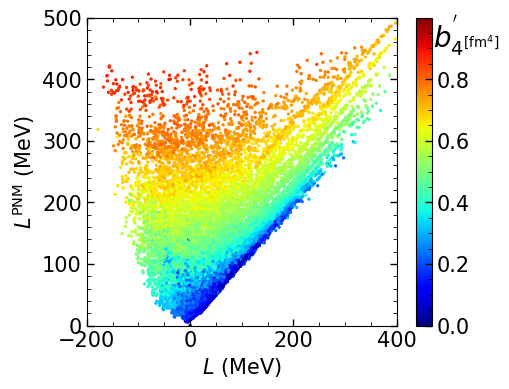

In [13]:
fig,ax=plt.subplots(1,1,figsize=(5,4),sharex=False,sharey=False)
c=np.concatenate(((eos_args_RMF_plot[4]/763**2+eos_args_RMF_plot[2]/980**2)/(8*939**2)*197.3**4,[0,1]))
#line3=plt.scatter(SAT_RMF[3],SAT_PNM_RMF[3],s=2,c=c, cmap='jet')
line3=ax.scatter(np.concatenate((SAT_RMF_plot[4],[0,-100])),np.concatenate((SAT_PNM_RMF_plot[4],[0,-100])),s=2,c=c, cmap='jet')
cbar=fig.colorbar(line3, ax=ax,ticks=np.linspace(0,0.8,5))
ax.text(470,450,'$b^{\'}_{4^{[\\rm{fm}^4]}}$',fontsize=20)
ax.set_xlabel('$L$ (MeV)',fontsize=15)
ax.set_ylabel('$L^{\\rm{PNM}}$ (MeV)',fontsize=15)
ax.set_xlim(-200,400)
ax.set_ylim(0,500)
fig.savefig('./figures/quadratic_approximation_RMF.pdf',bbox_inches = 'tight',format='pdf')
fig.savefig('./figures/quadratic_approximation_RMF.png',bbox_inches = 'tight',format='png')

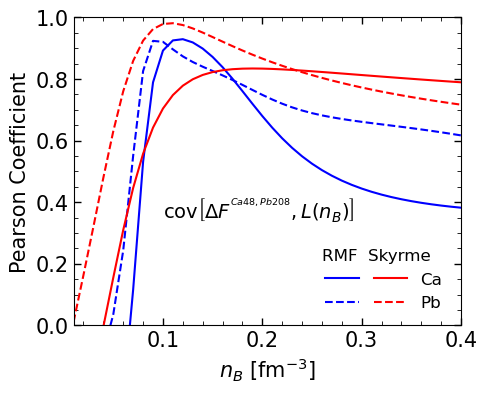

In [14]:
FchFwCa=PrexCrex_RMF_plot[0]-PrexCrex_RMF_plot[2]
FchFwPb=PrexCrex_RMF_plot[1]-PrexCrex_RMF_plot[3]
BulK_L=BulK_L_RMF_plot

plt.figure(figsize=(5,4))
plt.xlim(0.01,0.4)
plt.ylim(0,1)
plt.plot(np.linspace(0.01,0.4,40),np.corrcoef(FchFwCa,BulK_L)[0,1:],'-b',label=' ')
plt.plot(np.linspace(0.01,0.4,40),np.corrcoef(FchFwPb,BulK_L)[0,1:],'--b',label=' ')

FchFwCa=PrexCrex_Skyrme[0]-PrexCrex_Skyrme[2]
FchFwPb=PrexCrex_Skyrme[1]-PrexCrex_Skyrme[3]
BulK_L=BulK_L_Skyrme

plt.plot(np.linspace(0.01,0.4,40),np.corrcoef(FchFwCa,BulK_L)[0,1:],'-r',label='Ca')
plt.plot(np.linspace(0.01,0.4,40),np.corrcoef(FchFwPb,BulK_L)[0,1:],'--r',label='Pb')
plt.legend(frameon=False,fontsize=12,ncol=2,columnspacing=-0.2,title="RMF  Skyrme   ",title_fontsize=12)
plt.xlabel('$n_B$ [fm$^{-3}$]',fontsize=15)
plt.ylabel('Pearson Coefficient',fontsize=15)
plt.text(0.1,0.35,'cov$\\left[\Delta F^{^{Ca48,Pb208}}, L(n_B)\\right]$',fontsize=14)
plt.savefig('./figures/pearson_FL.pdf',bbox_inches = 'tight',format='pdf')

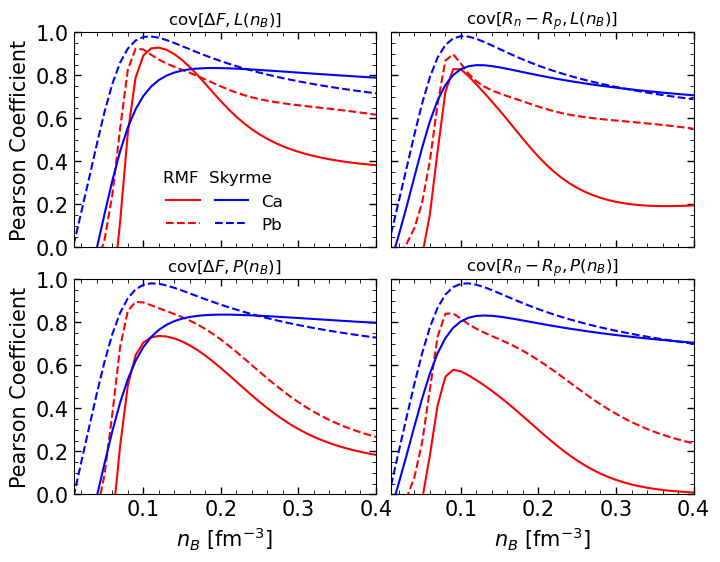

In [15]:
fig,axes_all=plt.subplots(2,2,figsize=(8,6),sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.15)
plt.xlim(0.01,0.4)
plt.ylim(0,1)
#for i,BulK_L in zip(range(2),[BulK_L_PNM_RMF,BulK_P_RMF]):
for i,BulK_L in zip(range(2),[BulK_L_RMF_plot,BulK_P_RMF_plot[:40]]):
    for j,FchFwCa,FchFwPb in zip(range(2),[PrexCrex_RMF_plot[0]-PrexCrex_RMF_plot[2],PrexCrex_RMF_plot[12]-PrexCrex_RMF_plot[13]],[PrexCrex_RMF_plot[1]-PrexCrex_RMF_plot[3],PrexCrex_RMF_plot[10]-PrexCrex_RMF_plot[11]]):
        axes_all[i,j].plot(np.linspace(0.01,0.4,40),np.corrcoef(FchFwCa,BulK_L)[0,1:],'-r',label=' ')
        axes_all[i,j].plot(np.linspace(0.01,0.4,40),np.corrcoef(FchFwPb,BulK_L)[0,1:],'--r',label=' ')

cov_type_i=['L','P']
cov_type_j=['\Delta F','R_n-R_p']
for i,BulK_L in zip(range(2),[BulK_L_Skyrme,BulK_P_Skyrme]):
    for j,FchFwCa,FchFwPb in zip(range(2),[PrexCrex_Skyrme[0]-PrexCrex_Skyrme[2],PrexCrex_Skyrme[12]-PrexCrex_Skyrme[13]],[PrexCrex_Skyrme[1]-PrexCrex_Skyrme[3],PrexCrex_Skyrme[10]-PrexCrex_Skyrme[11]]):
        axes_all[i,j].plot(np.linspace(0.01,0.4,40),np.corrcoef(FchFwCa,BulK_L)[0,1:],'-b',label='Ca')
        axes_all[i,j].plot(np.linspace(0.01,0.4,40),np.corrcoef(FchFwPb,BulK_L)[0,1:],'--b',label='Pb')
        axes_all[i,j].set_title("cov$\\left["+cov_type_j[j]+", "+cov_type_i[i]+"(n_B)\\right]$")
        #axes_all[i,j].legend(frameon=False,ncol=2,columnspacing=-0.2,title="RMF  Skyrme   ")
axes_all[0,0].legend(frameon=False,fontsize=12,ncol=2,columnspacing=-0.2,title="RMF  Skyrme   ",title_fontsize=12)
[axes_all[1,j].set_xlabel('$n_B$ [fm$^{-3}$]',fontsize=15) for j in [0,1]]
[axes_all[i,0].set_ylabel('Pearson Coefficient',fontsize=15) for i in [0,1]]
plt.savefig('./figures/pearson_FR_LP.pdf',bbox_inches = 'tight',format='pdf')